In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
import GO_utils
import utils
from os import listdir
from os.path import isfile, join

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Functions for Obtaining Experiment Results
# TODO: results w/out log-transforming the expression levels

In [120]:
def get_GO_gene_counts(input_file):
    counts_dict = {}
    counts_file = open(input_file)
    for (i, line) in enumerate(counts_file):
        if i < 2:
            continue
        data = line.rstrip().split('\t')
        counts_dict[data[0]] = int(data[1])
    counts_file.close()
    return counts_dict

def get_prediction_results(results_dir):
    results_files = [f for f in listdir(results_dir) if isfile(join(results_dir, f))]

    GO_terms = {}
    roc_auc_scores = []
    roc_auc_score_line = 2
    for rf in results_files:
        f = open(results_dir + '/' + rf)
        GO_term = None
        labels = []
        preds = []
        dec_func_scores = []
        probs = []
        for (i, line) in enumerate(f):
            if i == 0:
                GO_term = line.rstrip().split(' ')[-1]
            elif i == roc_auc_score_line:
                vals = line.rstrip().split(' ')
                roc_auc_scores.append(float(vals[-1]))
            elif line[0:4] == 'ENSG':
                vals = line.rstrip().split('\t')
                labels.append(int(vals[1]))
                preds.append(int(vals[2]))
                dec_func_scores.append(float(vals[3]))
                probs.append(float(vals[4]))
                
        GO_terms[GO_term] = (labels, preds, dec_func_scores, probs)
    return GO_terms, roc_auc_scores

def get_GO_gene_cnts():
    cnts_file = open('../data/GO_terms_final_gene_counts.txt')
    GO_to_num_genes = {}
    for (i, line) in enumerate(cnts_file):
        if i < 2:
            continue
        vals = line.rstrip().split('\t')
        GO_id = vals[0]
        num_genes = int(vals[1])
        GO_to_num_genes[GO_id] = num_genes
    return GO_to_num_genes
        

## Plot ROC Curves

In [125]:
def plot_roc(fprs, tprs, title):
    plt.figure()
    for (fpr, tpr) in zip(fprs, tprs):
        plt.plot(fpr, tpr, 'gray')
    plt.plot([0, 1], [0, 1], 'k--')  # Plot the 50% line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    
def plot_roc_heat(fprs, tprs, gene_cnts, title):
 
    NCURVES = len(gene_cnts)
    xs = fprs

    fig = plt.figure()
    ax = fig.add_subplot(111)

    cmap = plt.cm.YlOrRd
    min_count = int(min(gene_cnts))
    max_count = int(max(gene_cnts))
    print min_count, max_count
    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_count, vmax=max_count))

    for idx in range(NCURVES):
        colorVal = scalarMap.to_rgba(gene_cnts[idx])
        ax.plot(fprs[idx], tprs[idx], color=colorVal)
        
    ax.plot([0, 1], [0, 1], 'black')  # Plot the 50% line       

    # Generate colorbar
    scalarMap.set_array([])  # You have to set a dummy-array for this to work...
    cbar = plt.colorbar(scalarMap)
    cbar.set_label('# of Genes')
    #cbar.set_ticks(gene_cnts)
    #cbar.set_ticklabels(['{:4.1f}'.format(yi) for yi in y]) # Make 'em nicer-looking

    ax.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

    
def make_roc_curves(GO_terms_map, GO_cnts):
    false_pos_rates = []
    true_pos_rates = []
    GO_terms_list = GO_terms_map.keys()
    gene_counts = [GO_cnts[term] for term in GO_terms_list]
    sorted_tuples = sorted(zip(GO_terms_list, gene_counts), key=lambda tup: tup[1], reverse=False)
    GO_terms_list = [tup[0] for tup in sorted_tuples]
    gene_counts = [tup[1] for tup in sorted_tuples]
    auc_scores = []
    for term in GO_terms_list:
        (cur_labels, cur_preds, cur_decs, cur_probs) = GO_terms_map[term]
        cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_probs)
        
        #cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_decs)
        false_pos_rates.append(cur_fpr)
        true_pos_rates.append(cur_tpr)
        auc_scores.append(roc_auc_score(cur_labels, cur_probs))

    plot_roc(false_pos_rates, true_pos_rates, 'ROC for Log Transformed Expressions')
    plot_roc_heat(false_pos_rates, true_pos_rates, gene_counts, 'ROC for Log Transformed Expressions')
    
    plt.plot(gene_counts,auc_scores, "o")
    plt.xlabel('Gene Counts')
    plt.ylabel('AUC Score')
    ax = plt.gca()
    ax.grid()
    plt.show()

    return auc_scores
   

In [ ]:
## todo: "CDF" of AUC Scores For Increasing # of genes

## GO Terms that actually correspond to a GTEx Tissue

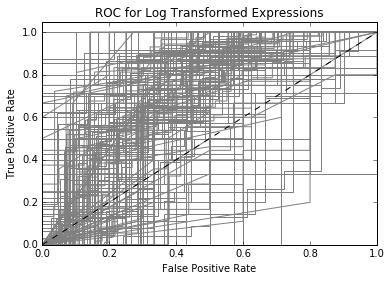

10 236


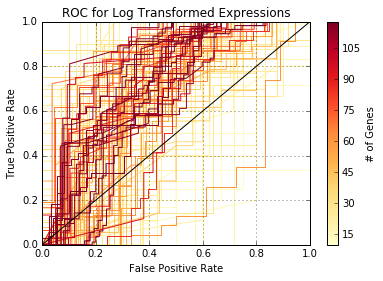

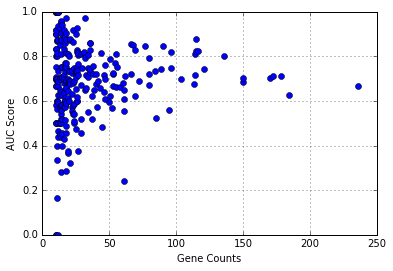

0.691208910805 0.691208910805


In [126]:
lt_GO_terms_sc, lt_roc_aucs_sc = get_prediction_results('results_terms_with_tissues_0')
# 'results_terms_with_tissues'
GO_gene_counts = get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')
aucs_prob = make_roc_curves(lt_GO_terms_sc, GO_gene_counts)
print np.mean(aucs_prob), np.mean(lt_roc_aucs_sc)

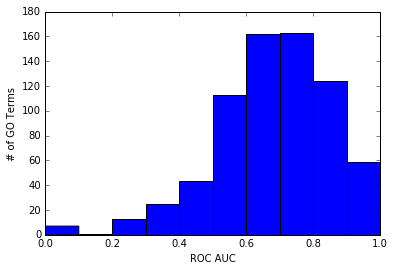

In [88]:
plt.hist(aucs_prob)
plt.xlim([0.0, 1.0])
plt.xlabel('ROC AUC')
plt.ylabel('# of GO Terms')
plt.show()

In [ ]:
# TODO: 5 fold CV! Consider doing the "CDF" plot

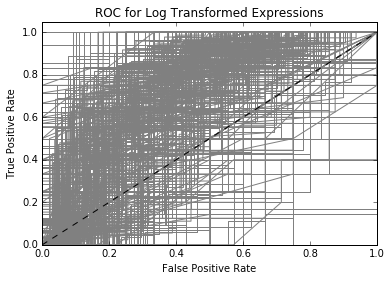

10 251


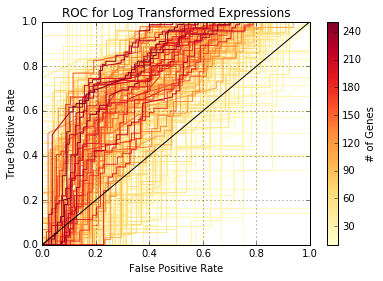

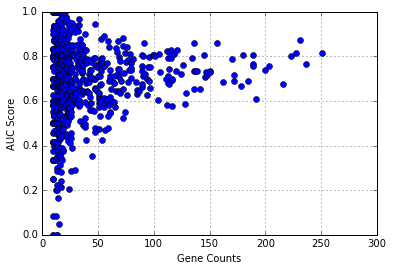

0.677452637059


In [92]:
lt_GO_terms_sc, lt_roc_aucs_sc = get_prediction_results('results_log_transformed_scaled_score_0')
aucs_prob = make_roc_curves(lt_GO_terms_sc, GO_counts)
print np.mean(aucs_prob)

In [106]:
print len(GO_counts.keys())

720
